In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
DATASET_PATH = "./data"
IMG_SIZE = 224
BATCH_SIZE = 32

# Create ImageDataGenerator with augmentation and a validation split (80/20)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,          # 80% training, 20% validation
    rotation_range=20,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 1377 images belonging to 3 classes.
Found 342 images belonging to 3 classes.


Class Labels: ['Cataract', 'Conjunctivitis', 'Normal']


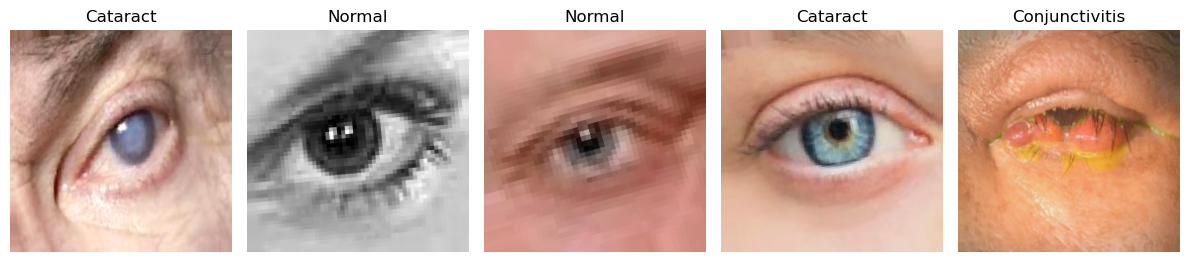

In [14]:
# Retrieve class names (should be: ['Cataract', 'Conjunctivitis', 'Normal'])
CLASS_NAMES = list(train_generator.class_indices.keys())
print("Class Labels:", CLASS_NAMES)

# Display a few sample images from the training set
sample_batch, sample_labels = next(train_generator)
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # Convert from [-1,1] to [0,1] for display
    plt.imshow((sample_batch[i] * 0.5) + 0.5)
    plt.title(CLASS_NAMES[np.argmax(sample_labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [16]:
# Load MobileNetV2 pretrained on ImageNet (exclude the top classification layers)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the base model

# Build a custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)  # Adjust dropout if needed
predictions = Dense(len(CLASS_NAMES), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=["accuracy"]
)

# Callbacks for training
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_modelu.h5", save_best_only=True, verbose=1)
]

In [ ]:
# Initial training (train custom head only)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=callbacks
)

# Fine-tuning: unfreeze the last 10 layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7918 - loss: 0.5040
Epoch 1: val_loss improved from inf to 0.06624, saving model to best_modelu.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.7938 - loss: 0.4994 - val_accuracy: 0.9766 - val_loss: 0.0662 - learning_rate: 0.0010
Epoch 2/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9482 - loss: 0.1213
Epoch 2: val_loss did not improve from 0.06624
44/44 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9482 - loss: 0.1214 - val_accuracy: 0.9620 - val_loss: 0.0981 - learning_rate: 0.0010
Epoch 3/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9367 - loss: 0.1316
Epoch 3: val_loss improved from 0.06624 to 0.05994, saving model to best_modelu.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9370 - loss: 0.1312 - val_accuracy: 0.9825 - val_loss: 0.0599 - learning_rate: 0.0010
Epoch 4/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9647 - loss: 0.0871
Epoch 4: val_loss improved from 0.05994 to 0.02566, saving model to best_modelu.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9649 - loss: 0.0867 - val_accuracy: 0.9912 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 5/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9849 - loss: 0.0521
Epoch 5: val_loss did not improve from 0.02566
44/44 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9847 - loss: 0.0523 - val_accuracy: 0.9854 - val_loss: 0.0385 - learning_rate: 0.0010
Epoch 6/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9848 - loss: 0.0495
Epoch 6: val_loss improved from 0.02566 to 0.02498, saving model to best_modelu.h5


44/44 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9848 - loss: 0.0497 - val_accuracy: 0.9883 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 7/40
24/44 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9920 - loss: 0.0294

In [ ]:
# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Continue training (fine-tuning)
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

# Save the final model as a TensorFlow SavedModel (needed for TFLite conversion)
saved_model_dir = "saved_model/eye_disease_model"
model.save(saved_model_dir)
print("Model saved to:", saved_model_dir)

In [ ]:
# Reset the validation generator and make predictions
val_generator.reset()
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

In [ ]:
# Plot training curves (loss and accuracy)
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"] + history_fine.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"] + history_fine.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.legend()
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"] + history_fine.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"] + history_fine.history["val_accuracy"], label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# Convert SavedModel to TFLite using Float16 Quantization
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_file = "eye_disease_model.tflite"
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)
print("TFLite model saved as:", tflite_model_file)


In [ ]:
# ======================================================
# 5. Test TFLite Model Inference and Provide Recommendations
# ======================================================

# Define a mapping from predicted class to symptoms and recommendations.
info_dict = {
    "Cataract": {
        "symptoms": "Blurred vision, sensitivity to light, faded colors.",
        "recommendations": "Consult an ophthalmologist; surgery may be required if vision is significantly impaired."
    },
    "Conjunctivitis": {
        "symptoms": "Redness, irritation, discharge, and swollen eyes.",
        "recommendations": "Maintain proper hygiene; consult a doctor as antibiotics or antivirals might be needed."
    },
    "Normal": {
        "symptoms": "No abnormal symptoms detected.",
        "recommendations": "Your eyes appear healthy. Continue routine eye care and annual check-ups."
    }
}

In [ ]:
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Load a sample image for inference (update the path as needed)
sample_image_path = "./data/normal/1.jpg"  
sample_img = cv2.imread(sample_image_path)
if sample_img is None:
    raise FileNotFoundError(f"Sample image not found at {sample_image_path}. Please check the path.")
# Convert image from BGR to RGB
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
sample_img = cv2.resize(sample_img, (IMG_SIZE, IMG_SIZE))
sample_img = np.expand_dims(sample_img, axis=0).astype(np.float32)
# Use MobileNetV2 preprocessing to scale to [-1,1]
sample_img = tf.keras.applications.mobilenet_v2.preprocess_input(sample_img)

In [ ]:
# Run inference with the TFLite model
interpreter.set_tensor(input_details[0]["index"], sample_img)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]["index"])
predicted_index = np.argmax(output_data)
predicted_class = CLASS_NAMES[predicted_index]

# Display prediction, symptoms, and recommendations
print(f"Predicted Eye Condition: {predicted_class}")
print("Symptoms Detected:", info_dict[predicted_class]["symptoms"])
print("Recommendations:", info_dict[predicted_class]["recommendations"])